# MLP demo

In this demo we will define and train a simple 3-layer multilayer perceptron (fully connected network) using `numpy` only.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Generate training data

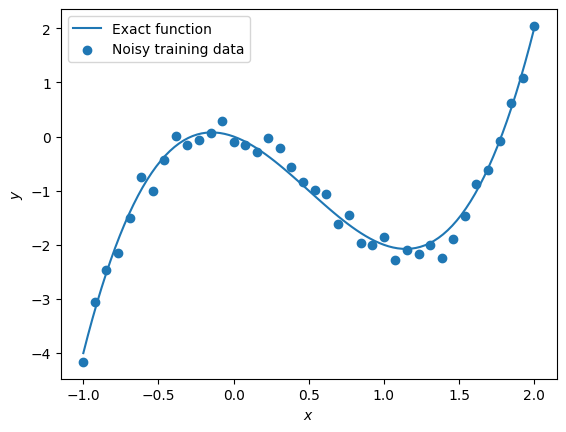

In [3]:
# Define some training data
lim = [-1,2]
x = np.linspace(*lim,40).reshape((-1,1,1))
x_true = np.linspace(*lim,100).reshape((-1,1,1))
y_fn = lambda theta, x: theta[3]*x**3 + theta[2]*x**2 + theta[1]*x + theta[0]
theta = [0,-1,-3,2]
y_true = y_fn(theta, x_true)
np.random.seed(123)
y = y_fn(theta, x) + np.random.normal(0,0.15,x.shape)

# Plot the training data
plt.figure()
plt.plot(x_true[:,0,0], y_true[:,0,0], label="Exact function")
plt.scatter(x[:,0,0], y[:,0,0], label="Noisy training data")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.show()

## Define and train MLP

We will define and train the following MLP:

$$
N\!N(\mathbf{x})= W_3(\sigma\,(W_2(\sigma\,(W_1 \mathbf{x} + \mathbf{b_1}) + \mathbf{b_2}) + \mathbf{b_3} = f \circ \mathbf{g} \circ \mathbf{h}\,(x) \\
\mathbf{h} = W_1 \mathbf{x} + \mathbf{b_1} \\
\mathbf{g} = W_2 \sigma\,(\mathbf{h}) + \mathbf{b_2} \\
f = W_3 \sigma\,(\mathbf{g}) + \mathbf{b_3} \\
$$

For which its gradients are given by (see lecture notes for derivation):

$$
\begin{align}
\frac{\partial L}{\partial W_1} &= \frac{\partial L}{\partial f} \frac{\partial f}{\partial \mathbf{g}} \frac{\partial \mathbf{g}}{\partial \mathbf{h}} \frac{\partial \mathbf{h}}{\partial W_1} \\
&= \frac{1}{N}\sum^{N}_{i} 2(f_i - y(\mathbf{x}_i)) \, W_3 \mathrm{diag}(\sigma'(\mathbf{g_i})) \, W_2 \mathrm{diag}(\sigma'(\mathbf{h_i})) \, \otimes \mathbf{x}_i
\end{align}
$$

In [4]:
print(x.shape, y.shape)# (N_examples, 1, 1)

(40, 1, 1) (40, 1, 1)


(40, 8, 1) (40, 16, 1) (40, 1, 1)
(40, 1, 8) (40, 1, 16) (40, 1, 1)
(1, 8, 1) (1, 16, 8) (1, 1, 16)
(1, 8, 1) (1, 16, 1) (1, 1, 1)


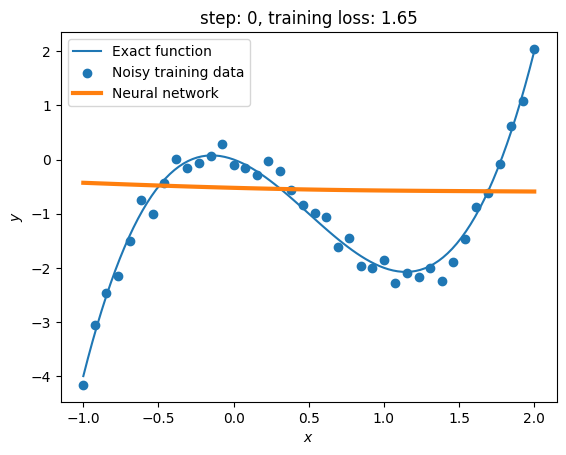

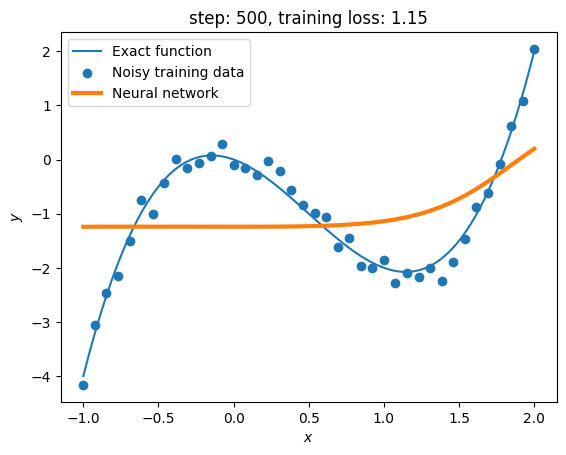

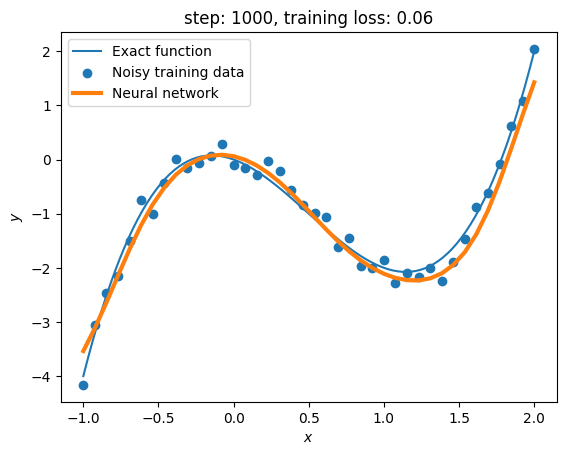

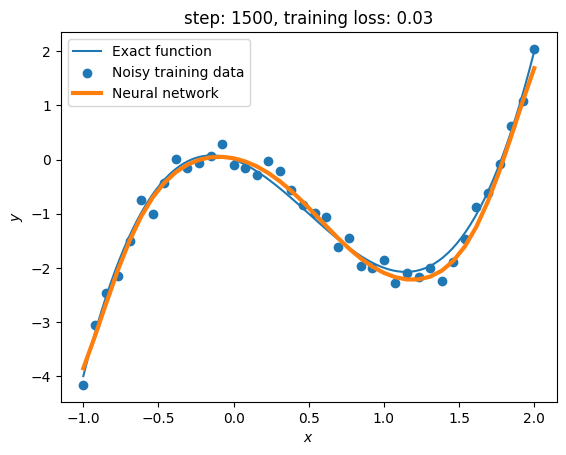

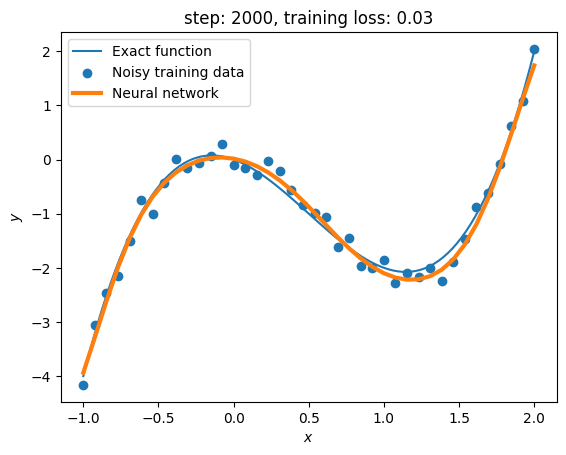

In [5]:
# define activation function
s = lambda x: np.tanh(x)
ds = lambda x: 1-np.tanh(x)**2# derivative of tanh

# Initialise weights
np.random.seed(0)
W1 = np.random.uniform(-1,1, (1, 8, 1))
W2 = np.random.uniform(-1,1, (1, 16, 8)) * np.sqrt(1/8)
W3 = np.random.uniform(-1,1, (1, 1, 16)) * np.sqrt(1/16)

b1 = np.random.uniform(-1,1, (1, 8, 1))
b2 = np.random.uniform(-1,1, (1, 16, 1)) * np.sqrt(1/8)
b3 = np.random.uniform(-1,1, (1, 1, 1)) * np.sqrt(1/16)

for i in range(2001):

    # forward pass
    h = W1 @ x + b1# h: (N_examples, 8, 1)
    g = W2 @ s(h) + b2# g: (N_examples, 16, 1)
    f = W3 @ s(g) + b3# f: (N_examples, 1, 1)

    # reverse-mode backpropagation
    dldf = 2 * (f - y)# dl/df: (N_examples, 1, 1)
    dldg = (dldf @ W3) @ (ds(g)*np.expand_dims(np.eye(16),0))# dl/dg: (N_examples, 1, 16)
    dldh = (dldg @ W2) @ (ds(h)*np.expand_dims(np.eye(8),0))# dl/dh: (N_examples, 1, 8)

    dW1 = (dldh * x).transpose(0,2,1)# dl/dW1: (N_examples, 8, 1)
    dW2 = (dldg * s(h)).transpose(0,2,1)# dl/dW2: (N_examples, 16, 8)
    dW3 = (dldf * s(g)).transpose(0,2,1)# dl/dW3: (N_examples, 1, 16)
    
    db1 = dldh.transpose(0,2,1)# dl/db1: (N_examples, 8, 1)
    db2 = dldg.transpose(0,2,1)# dl/db2: (N_examples, 16, 1)
    db3 = dldf.transpose(0,2,1)# dl/db3: (N_examples, 1, 1)

    # get mean gradient across training examples
    dW1 = np.mean(dW1, 0, keepdims=True)
    dW2 = np.mean(dW2, 0, keepdims=True)
    dW3 = np.mean(dW3, 0, keepdims=True)
    db1 = np.mean(db1, 0, keepdims=True)
    db2 = np.mean(db2, 0, keepdims=True)
    db3 = np.mean(db3, 0, keepdims=True)
    
    # gradient descent step
    a = 0.05# learning rate
    W1 -= a * dW1
    W2 -= a * dW2
    W3 -= a * dW3
    b1 -= a * db1
    b2 -= a * db2
    b3 -= a * db3
    
    if i == 0: 
        print(h.shape, g.shape, f.shape)
        print(dldh.shape, dldg.shape, dldf.shape)
        print(dW1.shape, dW2.shape, dW3.shape)
        print(db1.shape, db2.shape, db3.shape)
        
    if i % 500 == 0: 
        
        # get loss value
        l = np.mean((f-y)**2)
        
        # Plot the training data
        plt.figure()
        plt.title(f"step: {i}, training loss: {l:.2f}")
        plt.plot(x_true[:,0,0], y_true[:,0,0], label="Exact function")
        plt.scatter(x[:,0,0], y[:,0,0], label="Noisy training data")
        plt.plot(x[:,0,0], f[:,0,0], lw=3, label="Neural network")
        plt.xlabel("$x$")
        plt.ylabel("$y$")
        plt.legend()
        plt.show()